# Importing libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Loading dataset

In [2]:
def load_dataset(dataset_path="data"):
    images, annotations = [], []
    
    vehicle_dir = os.path.join(dataset_path, "vehicles")
    vehicle_images = [os.path.join(vehicle_dir, path) for path in os.listdir(vehicle_dir)]
    images.extend(vehicle_images)
    annotations.extend([1] * len(vehicle_images))
    
    non_vehicle_dir = os.path.join(dataset_path, "non-vehicles")
    non_vehicle_images = [os.path.join(non_vehicle_dir, path) for path in os.listdir(non_vehicle_dir)]
    images.extend(non_vehicle_images)
    annotations.extend([0] * len(non_vehicle_images))
    
    print(f"Dataset size: ({len(images)}, {len(annotations)})")
    return images, annotations

# Transormation annotation and augmentation

In [ ]:
class VehicleDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image = read_image(self.images[index]) / 255
        annotation = self.annotations[index]

        if self.transform:
            image = self.transform(image)

    transform = transforms.Compose([
    transforms.Resize((32, 32)),       
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),             
    transforms.Normalize((0.5,), (0.5,))  
])
        
return image, annotation

# CNN

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Training and evaluation phase

In [5]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    loss_values = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_values.append(epoch_loss / len(train_loader))
    return loss_values

In [6]:
def evaluate_model(model, test_loader):
    predictions, actuals = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            preds = (outputs.cpu().numpy() > 0.5).astype(int)
            predictions.extend(preds.flatten())
            actuals.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(actuals, predictions)
    print(f"Accuracy: {accuracy:.4f}")
    report_df = pd.DataFrame(classification_report(actuals, predictions, zero_division=0, output_dict=True))
    print(report_df.T)
    return accuracy, report_df

In [7]:
def plot_loss(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

Dataset size: (17760, 17760)


Epoch 100: 100%|██████████| 195/195 [00:04<00:00, 41.42it/s]


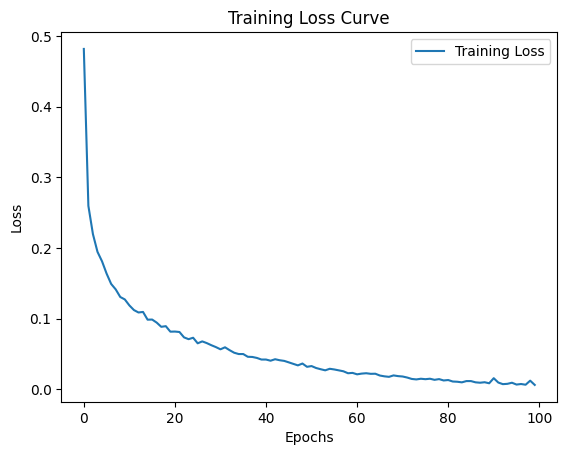

Evaluating: 100%|██████████| 84/84 [00:29<00:00,  2.88it/s]

Accuracy: 0.9854
              precision    recall  f1-score     support
0              0.988355  0.982450  0.985393  2678.00000
1              0.982371  0.988302  0.985327  2650.00000
accuracy       0.985360  0.985360  0.985360     0.98536
macro avg      0.985363  0.985376  0.985360  5328.00000
weighted avg   0.985378  0.985360  0.985360  5328.00000
Model saved successfully!


In [8]:
images, annotations = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(images, annotations, test_size=0.3, random_state=432)

train_loader = DataLoader(VehicleDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(VehicleDataset(X_test, y_test), batch_size=64, shuffle=False)

model = ClassificationModel().to("cuda")
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

loss_values = train_model(model, train_loader, criterion, optimizer)
plot_loss(loss_values)

accuracy, report_df = evaluate_model(model, test_loader)

torch.save(model.state_dict(), "vehicle_classifier.pth")
print("Model saved successfully!")